In [1]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [2]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))


In [4]:
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves

In [18]:
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

len(np.where(np.array(y_test)=='rho')[0])

5

In [3]:
all_counts=[]
for lc in lcs:
    all_counts.append(lc[1])
all_counts_ar=np.concatenate(all_counts, axis=0)
armean=np.mean(all_counts_ar)
arstd=np.std(all_counts_ar)
armedian=np.median(all_counts_ar)
sigma4=armean+4*arstd
print(armean,arstd,armedian, sigma4)
below4sigma=100-len(np.where(all_counts_ar>sigma4)[0])/len(all_counts_ar)*100

2618.632056618424 1490.670975229398 2178.0 8581.315957536015


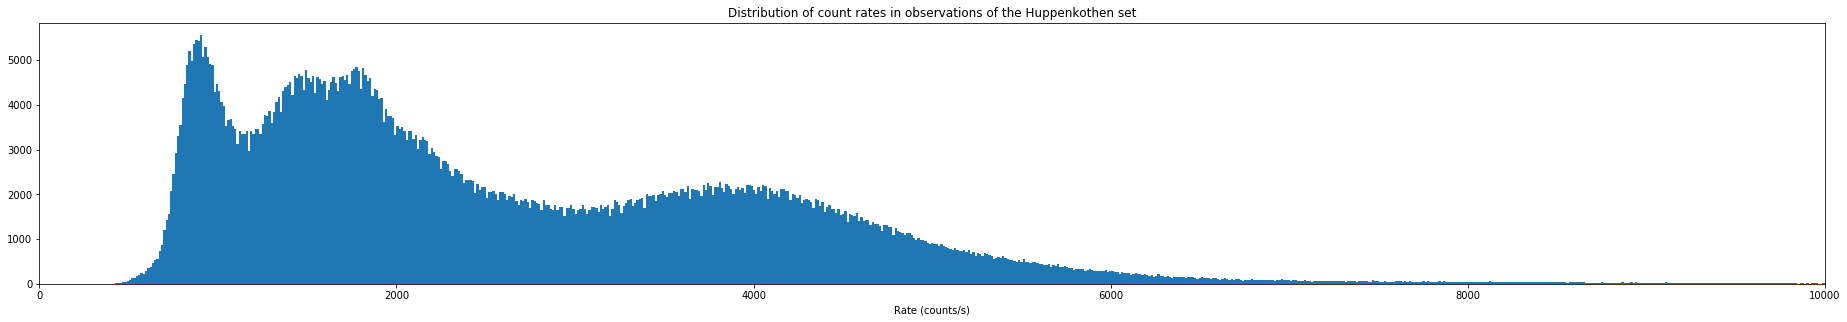

In [7]:
plt.figure(figsize=(6.4*5, 4.8))
plt.hist(all_counts_ar,bins=1000)
plt.xlim(0,10000)
plt.title("Distribution of count rates in observations of the Huppenkothen set")
plt.xlabel("Rate (counts/s)")
#plt.savefig("rates_hist_1kbins.png", dpi=600)
plt.show()

In [34]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type="tied")
gmm.fit(all_counts_ar.reshape(-1, 1))
gmm.means_

array([[4238.09638343],
       [1555.33100849],
       [7278.77137012],
       [2539.15565663]])

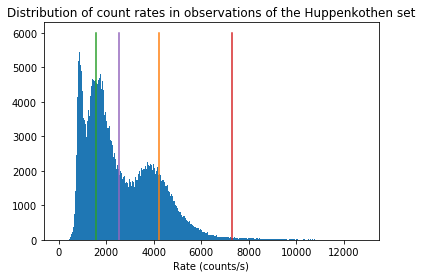

In [35]:
plt.hist(all_counts_ar,bins=1000)
plt.title("Distribution of count rates in observations of the Huppenkothen set")
plt.xlabel("Rate (counts/s)")
for meanval in gmm.means_:
    plt.plot([meanval,meanval],[0,6000])
plt.show()

In [11]:
from sklearn import mixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(all_counts_ar.reshape(-1, 1))
        bic.append(gmm.bic(all_counts_ar.reshape(-1, 1)))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

ValueError: expected square matrix

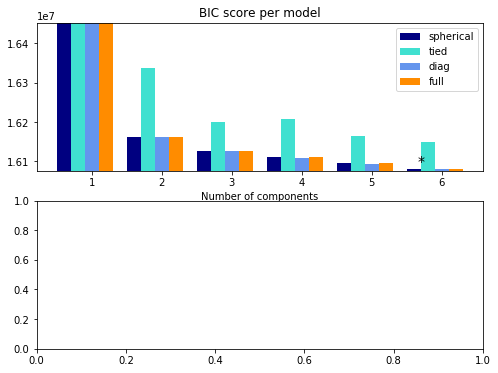

In [15]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(all_counts_ar.reshape(-1, 1))
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(all_counts_ar.reshape(-1, 1)[Y_ == i, 0], all_counts_ar.reshape(-1, 1)[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

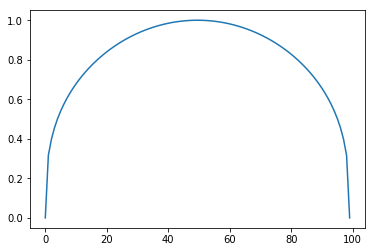

In [34]:
window_rads = np.linspace(0, np.pi, 100)
window_sin = np.sin(window_rads)**(1/3)
plt.plot(window_sin)

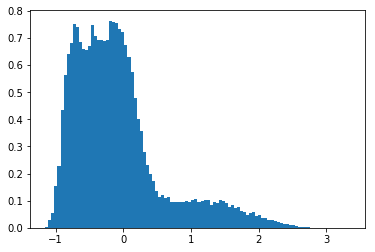

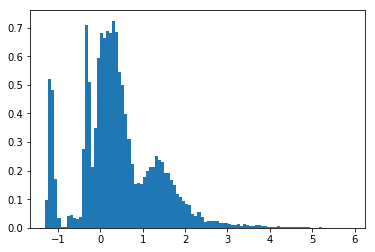

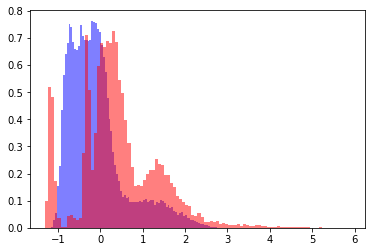

In [348]:
all_counts=[]
class_ids=np.where(np.array(y_train)=='rho')[0]
for lc_id in class_ids:
    lc=x_train[lc_id]
    all_counts.append(lc[1])
all_counts_ar=np.concatenate(all_counts, axis=0)

all_counts=[]
class_ids=np.where(np.array(y_valid)=='rho')[0]
for lc_id in class_ids:
    lc=x_train[lc_id]
    all_counts.append(lc[1])
all_counts_ar2=np.concatenate(all_counts, axis=0)

plt.hist(all_counts_ar, bins=100, density=True)
plt.show()
plt.hist(all_counts_ar2, bins=100,density=True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_counts_ar, bins=100, alpha = 0.5, lw=3, color= 'b',density=True)
ax.hist(all_counts_ar2, bins=100, alpha = 0.5, lw=3, color= 'r',density=True)
# ax.set_xlim(-1.5, 3)
# ax.set_ylim(0, 2)
plt.show()